# Pré-processamento de Dados
## | Avaliando Riscos de Modelo e Selecionando Variáveis Explicativas

### > **Objetivo do Notebook**: 

Este notebook é a 2ª parte do desenvolvimento do projeto focado para construção de um modelo preditivo para classificar alunos com alta chance de evasão do ensino superior. O foco desse notebook será em avaliar os riscos do modelo, dado a abordagem que será usada para a modelagem e selecionar as variáveis explicativas de maior importância através do conceito de *Feature Engineering*. 

### > **Insights da Exploração**

Com base no jupyter notebook anterior, já possuímos uma base com qual podemos começar o trabalho de avaliar as variáveis explicativas.


- Multicolinearidade (VIF)
- Outliers (Z-score)
- Information Gain
- Transformação das variáveis
- Normalização das variáveis
- Regularização Elastic Net
- Ajustes de Hiperparâmetros

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from scipy.stats import pointbiserialr, f_oneway, chi2_contingency
from collections import defaultdict
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [2]:
# Listando variáveis de interesse
vars = [
    'Curricular units 1st sem (approved)',
    'Curricular units 1st sem (grade)',
    'Curricular units 2nd sem (approved)',
    'Curricular units 2nd sem (grade)',
    'Tuition fees up to date',
    'Scholarship holder',
    'Course',
    'Application mode',
    'Target'
]

# Extraindo dados
df = pd.read_csv('../data/raw/train.csv')

# Selecionando apenas variáveis de interesse
df_sub = df[vars].copy()

# Mapeando Target para estudar apenas o caso de evasão de alunos
df_sub['Target'] = df_sub['Target'].map({'Graduate': 0, 'Enrolled': 0, 'Dropout': 1})

df_sub.head(5)

,Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Tuition fees up to date,Scholarship holder,Course,Application mode,Target
0,6,14.500000,6,12.428571,1,1,9238,1,0
1,4,11.600000,0,0.000000,1,0,9238,17,1
2,0,0.000000,0,0.000000,1,0,9254,17,1
3,7,12.591250,7,12.820000,1,1,9500,1,0
4,6,12.933333,6,12.933333,1,0,9500,1,0


In [3]:
# Separando variáveis por categoricas
vars_continuas = vars[0:4]
vars_bin = [col for col in df_sub.columns if set(df_sub[col].unique()) <= {0, 1}]
vars_nominais = list(set(vars[4:]).difference(set(vars_bin)))

df_sub[vars_bin].head(5)

,Tuition fees up to date,Scholarship holder,Target
0,1,1,0
1,1,0,1
2,1,0,1
3,1,1,0
4,1,0,0


# | Riscos do Modelo

## | Multicolinearidade

In [4]:
# Função para calcular a Correlação de Phi para Variáveis Binárias
def phi_coefficient(x, y):
    contingency_table = pd.crosstab(x, y)
    chi2, _, _, _ = chi2_contingency(contingency_table)
    n = contingency_table.sum().sum()
    return np.sqrt(chi2 / n)

# Função para calcular a Correlação entre Variáveis Categóricas
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2, _, _, _ = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    r, k = confusion_matrix.shape
    return np.sqrt(chi2 / (n * (min(r, k) - 1)))

# Função para calcular a Correlação entre Variáveis Contínuas e Binárias
def calculate_pointbiserialr(df, var_con, var_bin):
    corr, _ = pointbiserialr(x=df[var_bin], y=df[var_con])
    return corr

# Função para calcular o p-value entre Variáveis Contínuas e Nominais
def calculate_anova(df, var_con, var_nom):
    _, p_value = f_oneway(*[df[df[var_nom] == category][var_con] for category in df[var_nom].unique()])
    return p_value

# Dicionário para armazenar todas as correlações de todas as variáveis entre si
corr_vars = defaultdict(dict)

# Correlações de Pearson das Variáveis Contínuas entre si
corr_con = df_sub[vars_continuas].corr()

# Mapeando dicionário com as correlações das variáveis contínuas
for col in corr_con:
    corr_vars[col] = corr_con[col].to_dict()

# Mapeando dicionário com as correlações das variáveis contínuas e binárias
for var_con in vars_continuas:
    for var_bin in vars_bin:
        corr_vars[var_con][var_bin] = calculate_pointbiserialr(df_sub, var_con, var_bin)

# Mapeando dicionário com o p_value das variáveis contínuas e nominais
for var_con in vars_continuas:
    for var_nom in vars_nominais:
        corr_vars[var_con][var_nom] = calculate_anova(df_sub, var_con, var_nom)

# Mapeando dicionário com as correlações de phi das variáveis binárias entre si
for var_bin1 in vars_bin:
    for var_bin2 in vars_bin:
        corr_vars[var_bin1][var_bin2] = phi_coefficient(df_sub[var_bin1], df_sub[var_bin2])

# Mapeando dicionário com as correlações das variáveis binárias e nominais
for var_bin in vars_bin:
    for var_nom in vars_nominais:
        corr_vars[var_bin][var_nom] = cramers_v(df_sub[var_bin], df_sub[var_nom])

# Mapeando dicionário com as correlações das variáveis nominais entre si
for var_nom1 in vars_nominais:
    for var_nom2 in vars_nominais:
        corr_vars[var_nom1][var_nom2] = cramers_v(df_sub[var_nom1], df_sub[var_nom2])

# Criando um novo dicionário para armazenar as correlações organizadas
complete_corr_vars = defaultdict(dict)

# Preenchendo o novo dicionário com todas as correlações
for key in corr_vars:
    for other_key in corr_vars:
        if other_key in corr_vars[key]:
            complete_corr_vars[key][other_key] = corr_vars[key][other_key]
        elif key in corr_vars[other_key]:
            complete_corr_vars[key][other_key] = corr_vars[other_key][key]
        else:
            complete_corr_vars[key][other_key] = 0.0

# Salvando o dicionário de correlação em DataFrame
correlations = pd.DataFrame(complete_corr_vars)
correlations

,Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Tuition fees up to date,Scholarship holder,Target,Course,Application mode
Curricular units 1st sem (approved),1.000000,0.839860,0.922657,0.830430,0.343467,0.328211,-0.689017,0.000000,0.000000
Curricular units 1st sem (grade),0.839860,1.000000,0.787559,0.889393,0.341496,0.273642,-0.681377,0.000000,0.000000
Curricular units 2nd sem (approved),0.922657,0.787559,1.000000,0.859370,0.370150,0.355532,-0.731006,0.000000,0.000000
Curricular units 2nd sem (grade),0.830430,0.889393,0.859370,1.000000,0.381380,0.295095,-0.743454,0.000000,0.000000
Tuition fees up to date,0.343467,0.341496,0.370150,0.381380,0.999931,0.167187,0.446433,0.199234,0.286637
Scholarship holder,0.328211,0.273642,0.355532,0.295095,0.167187,0.999965,0.316025,0.282594,0.242556
Target,-0.689017,-0.681377,-0.731006,-0.743454,0.446433,0.316025,0.999970,0.337880,0.399019
Course,0.000000,0.000000,0.000000,0.000000,0.199234,0.282594,0.337880,1.000000,0.174155
Application mode,0.000000,0.000000,0.000000,0.000000,0.286637,0.242556,0.399019,0.174155,1.000000


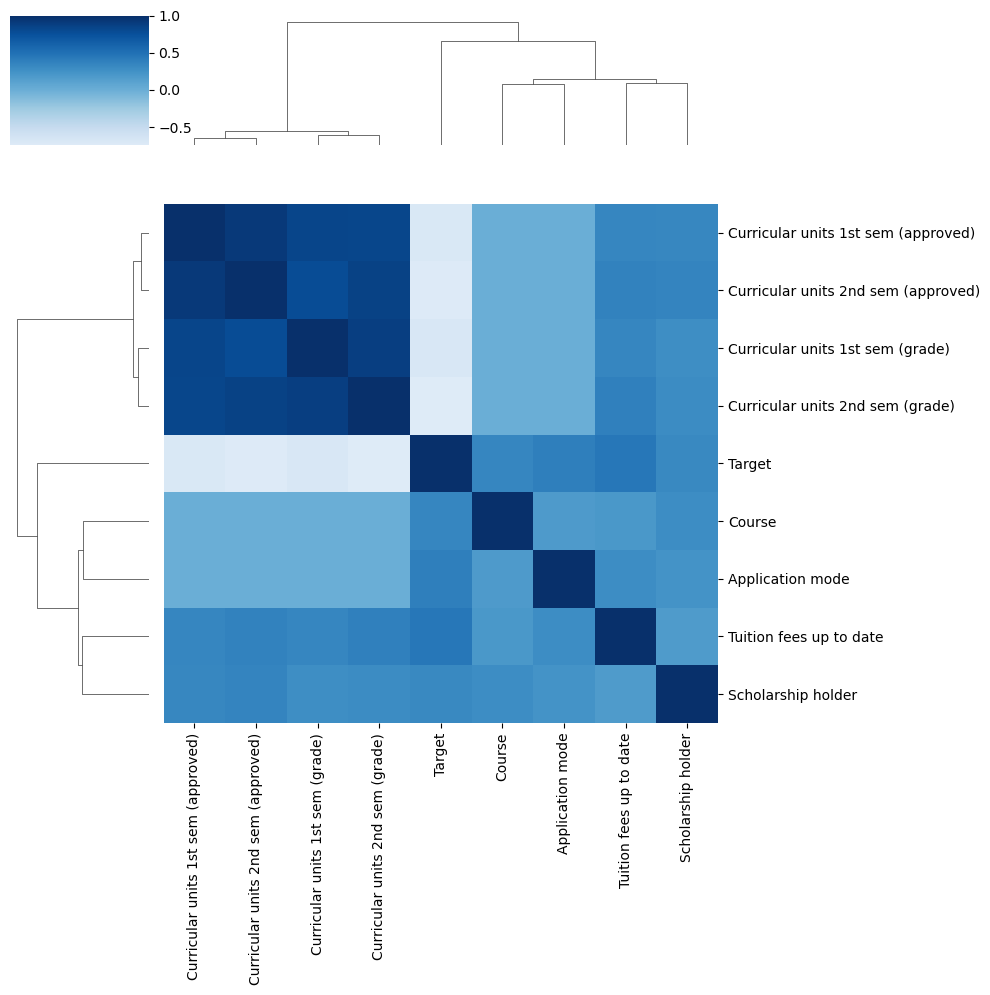

In [5]:
# Visualizando gráfico das correlações
sns.clustermap(correlations, center=0, cmap='Blues')
plt.tight_layout()
plt.show()

In [6]:
# Definindo função para classificar VIF
def classify_vif(vif: int) -> str:
    if vif <= 1:
        return 'Baixa'
    elif 1 < vif < 5:
        return 'Moderada'
    elif 10 > vif >= 5:
        return 'Alta'
    elif vif >= 10:
        return 'Severa'

# Definindo função para criar a tabela de VIF
def create_vif_table(X: pd.DataFrame) -> pd.DataFrame:
    vif_table = pd.DataFrame()
    vif_table['Variável'] = X.columns
    vif_table['VIF'] = [vif(X.values, i) for i in range(X.shape[1])]
    vif_table['Classificação'] = [classify_vif(vif) for vif in vif_table['VIF']]
    return vif_table

In [7]:
# Calcular Variance Inflation Factor com as Variáveis Pré-selecionadas
vif_table_1 = create_vif_table(X=df_sub.drop('Target', axis=1))
vif_table_1

,Variável,VIF,Classificação
0,Curricular units 1st sem (approved),31.076562,Severa
1,Curricular units 1st sem (grade),29.664165,Severa
2,Curricular units 2nd sem (approved),28.994451,Severa
3,Curricular units 2nd sem (grade),29.716265,Severa
4,Tuition fees up to date,8.388704,Alta
5,Scholarship holder,1.544444,Moderada
6,Course,11.595083,Severa
7,Application mode,2.106260,Moderada


Observando o gráfico e a tabela acima, notamos que as variáveis pré-selecionadas no notebook anterior tem um altíssimo grau de autocorrelação, o que leva a **multicolinearidade**. Outra observação interessante, as variáveis apontadas como as com maior correlação entre as demais são as variáveis contínuas do modelo. Com base nisso, vamos conduzir uma **análise de componentes principais** com o intuito de combinar as informações que as variáveis contínuas trazem ao modelo, de forma a reduzir sua autocorrelação.

In [8]:
# Combinação linear das variáveis contínuas
scaler = StandardScaler()

pca_4 = PCA(n_components=4)  
principal_components_4 = pca_4.fit_transform(scaler.fit_transform(df_sub[vars_continuas]))

explained_variance_4 = pca_4.explained_variance_ratio_
print('Razão de Variância Explicada por Cada Componente:', explained_variance_4)

Razão de Variância Explicada por Cada Componente: [0.89121955 0.06301028 0.03331335 0.01245682]


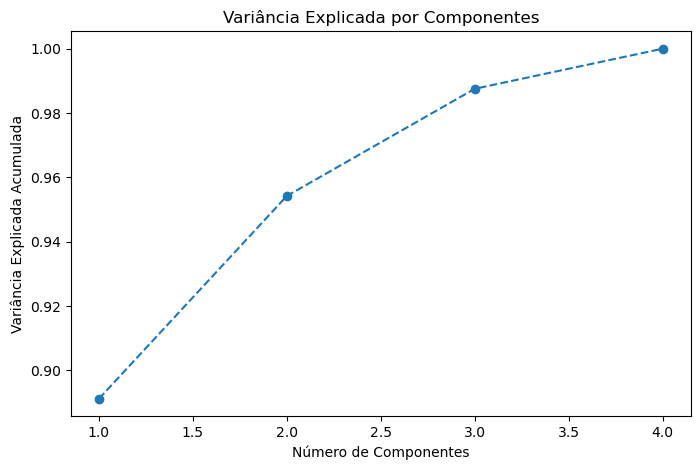

In [9]:
# Visualizando a variância explicada acumulada de cada componente
plt.figure(figsize=(8,5))
plt.plot(range(1, len(explained_variance_4)+1), np.cumsum(explained_variance_4), marker='o', linestyle='--')
plt.xlabel('Número de Componentes')
plt.ylabel('Variância Explicada Acumulada')
plt.title('Variância Explicada por Componentes')
plt.show()

In [10]:
# Criando um dataframe com as componentes principais
df_pca = pd.DataFrame(principal_components_4, 
                      columns=[f'PC{i+1}_vc' for i in range(len(vars_continuas))])

# Combinando os dataframes
df_sub = pd.concat([df_sub.drop(vars_continuas, axis=1), df_pca], axis=1)
df_sub.head(5)

,Tuition fees up to date,Scholarship holder,Course,Application mode,Target,PC1_vc,PC2_vc,PC3_vc,PC4_vc
0,1,1,9238,1,0,1.377008,-0.032112,0.191097,0.171448
1,1,0,9238,17,1,-1.478385,-0.372044,1.695335,-0.000335
2,1,0,9254,17,1,-3.314795,0.357917,-0.083664,-0.010029
3,1,1,9500,1,0,1.601885,0.522358,0.049436,0.007627
4,1,0,9500,1,0,1.275992,0.118435,-0.010658,0.018867


In [11]:
# Criando a nova tabela de VIF
vif_table_2 = create_vif_table(X=df_sub.drop('Target', axis=1))
vif_table_2

,Variável,VIF,Classificação
0,Tuition fees up to date,7.681396,Alta
1,Scholarship holder,1.526307,Moderada
2,Course,9.004621,Alta
3,Application mode,2.166297,Moderada
4,PC1_vc,1.223072,Moderada
5,PC2_vc,1.026366,Moderada
6,PC3_vc,1.011334,Moderada
7,PC4_vc,1.005435,Moderada


Graças a correção das variáveis usando a **Análise de Componentes Principais**, conseguimos melhorar as variáveis. Contudo as variáveis **Tuition fees up to date** e **Course** ainda posuem um VIF alto. Para corrigir esse problema, vamos trazer a variável **Debtor** do dataframe original, que possui uma correlação considerável com **Tuition fees up to date** e vamos combinar as duas variáveis em dois componentes principais.

In [12]:
# Selecionando variáveis features
features  = ['Debtor', 'Tuition fees up to date']

# Criando componentes principais
pca_2 = PCA(n_components=2)  
principal_components_2 = pca_2.fit_transform(scaler.fit_transform(df[features]))

print('Razão de Variância Explicada:', pca_2.explained_variance_ratio_)

Razão de Variância Explicada: [0.73768126 0.26231874]


In [13]:
# Criando dataframe com componentes principais
df_pca_2 = pd.DataFrame(principal_components_2, 
                      columns=[f'PC{i+1}_vb' for i in range(len(features))])
df_sub = pd.concat([df_sub.drop('Tuition fees up to date', axis=1), df_pca_2], axis=1)
df_sub.head(5)

,Scholarship holder,Course,Application mode,Target,PC1_vc,PC2_vc,PC3_vc,PC4_vc,PC1_vb,PC2_vb
0,1,9238,1,0,1.377008,-0.032112,0.191097,0.171448,-0.439985,0.047891
1,0,9238,17,1,-1.478385,-0.372044,1.695335,-0.000335,-0.439985,0.047891
2,0,9254,17,1,-3.314795,0.357917,-0.083664,-0.010029,-0.439985,0.047891
3,1,9500,1,0,1.601885,0.522358,0.049436,0.007627,-0.439985,0.047891
4,0,9500,1,0,1.275992,0.118435,-0.010658,0.018867,-0.439985,0.047891


In [14]:
# Criando terceira tabela de VIF
vif_table_3 = create_vif_table(X=df_sub.drop('Target', axis=1))
vif_table_3

,Variável,VIF,Classificação
0,Scholarship holder,1.508403,Moderada
1,Course,2.560056,Moderada
2,Application mode,2.188509,Moderada
3,PC1_vc,1.341622,Moderada
4,PC2_vc,1.023785,Moderada
5,PC3_vc,1.013460,Moderada
6,PC4_vc,1.005931,Moderada
7,PC1_vb,1.156794,Moderada
8,PC2_vb,1.045079,Moderada


Graças as alterações, as variáveis agora apresentam uma taxa aceitável de **Variance Inflation Factor**, o que reduz considerevalmente o risco de **multicolinearidade** no modelo final.

No modelo, ainda possuimos duas variáveis de múltiplas classes, vamos transforma-las em binárias.

In [15]:
# Formas de aplicação
aplicacoes = {
    1: "1ª fase – contingente geral",
    2: "Portaria nº 612/93",
    5: "1ª fase - contingente especial (Ilha dos Açores)",
    7: "Titulares de outros cursos superiores",
    10: "Portaria nº 854-B/99",
    15: "Estudante internacional (bacharelado)",
    16: "1ª fase – contingente especial (Ilha da Madeira)",
    17: "2ª fase – contingente geral",
    18: "3ª fase – contingente geral",
    26: "Portaria n.º 533-A/99, alínea b2) (Plano Diferente)",
    27: "Portaria nº 533-A/99, item b3 (Outra Instituição)",
    39: "Maiores de 23 anos",
    42: "Transferência",
    43: "Mudança de curso",
    44: "Titulares de diploma de especialização tecnológica",
    51: "Mudança de instituição/curso",
    53: "Titulares de diplomas de ciclo curto",
    57: "Mudança de instituição/curso (Internacional)"
}

# Mapeando variável course para facilitar leitura
df_sub['Application mode'] = df_sub['Application mode'].map(aplicacoes)

# Removendo valores não identificados
df_sub.dropna(subset='Application mode', inplace=True)

df_sub.head(5)

,Scholarship holder,Course,Application mode,Target,PC1_vc,PC2_vc,PC3_vc,PC4_vc,PC1_vb,PC2_vb
0,1,9238,1ª fase – contingente geral,0,1.377008,-0.032112,0.191097,0.171448,-0.439985,0.047891
1,0,9238,2ª fase – contingente geral,1,-1.478385,-0.372044,1.695335,-0.000335,-0.439985,0.047891
2,0,9254,2ª fase – contingente geral,1,-3.314795,0.357917,-0.083664,-0.010029,-0.439985,0.047891
3,1,9500,1ª fase – contingente geral,0,1.601885,0.522358,0.049436,0.007627,-0.439985,0.047891
4,0,9500,1ª fase – contingente geral,0,1.275992,0.118435,-0.010658,0.018867,-0.439985,0.047891


In [16]:
# Cursos
cursos = {
    33: "Tecnologias de Produção de Biocombustíveis",
    171: "Animação e Design Multimédia",
    8014: "Serviço Social (atendimento noturno)",
    9003: "Agronomia",
    9070: "Design de Comunicação",
    9085: "Enfermagem Veterinária",
    9119: "Engenharia Informática",
    9130: "Equinicultura",
    9147: "Gestão",
    9238: "Serviço Social",
    9254: "Turismo",
    9500: "Enfermagem",
    9556: "Higiene Oral",
    9670: "Gestão de Publicidade e Marketing",
    9773: "Jornalismo e Comunicação",
    9853: "Ensino Básico",
    9991: "Gestão (atendimento noturno)"
}

# Mapeando variável course para facilitar leitura
df_sub['Course'] = df_sub['Course'].map(cursos)

# Removendo valores não identificados
df_sub.dropna(subset='Course', inplace=True)

df_sub.head(5)

,Scholarship holder,Course,Application mode,Target,PC1_vc,PC2_vc,PC3_vc,PC4_vc,PC1_vb,PC2_vb
0,1,Serviço Social,1ª fase – contingente geral,0,1.377008,-0.032112,0.191097,0.171448,-0.439985,0.047891
1,0,Serviço Social,2ª fase – contingente geral,1,-1.478385,-0.372044,1.695335,-0.000335,-0.439985,0.047891
2,0,Turismo,2ª fase – contingente geral,1,-3.314795,0.357917,-0.083664,-0.010029,-0.439985,0.047891
3,1,Enfermagem,1ª fase – contingente geral,0,1.601885,0.522358,0.049436,0.007627,-0.439985,0.047891
4,0,Enfermagem,1ª fase – contingente geral,0,1.275992,0.118435,-0.010658,0.018867,-0.439985,0.047891


Target Encoding (Mean Encoding)
Como você tem muitas categorias, Target Encoding (codificação baseada na variável alvo) pode ser uma boa alternativa. Isso evita criar muitas colunas e reduz a redundância nos dados.

Passos para aplicar Target Encoding

1️⃣ Substituir cada categoria pela média da variável alvo (por exemplo, taxa de sucesso ou outra métrica relevante).

2️⃣ Usar validação cruzada (K-Fold) para evitar vazamento de dados.

In [17]:
# Aplicando Target Encoding
from sklearn.model_selection import KFold

# Copiar os dados originais
df_encoded = df_sub.copy()

kf = KFold(n_splits=5, shuffle=True, random_state=412)

# Para cada variável nominal
for var in vars_nominais:
    df_encoded[var + '_encoded'] = 0.0 
    # Para cada divisão de treino/validação
    for train_idx, val_idx in kf.split(df_encoded):
        # Calcular a média do target para cada categoria
        mean_target = df_encoded.iloc[train_idx].groupby(var)['Target'].mean()
        
        # Mapear a média no conjunto de validação
        df_encoded.loc[df_encoded.index[val_idx], var + '_encoded'] = df_encoded.loc[df_encoded.index[val_idx], var].map(mean_target)
    
    # Garantir que a coluna codificada seja do tipo float64
    df_encoded[var + '_encoded'] = df_encoded[var + '_encoded'].astype(float)

# Remover as colunas originais
df_encoded.drop(vars_nominais, inplace=True, axis=1)

df_encoded

,Scholarship holder,Target,PC1_vc,PC2_vc,PC3_vc,PC4_vc,PC1_vb,PC2_vb,Course_encoded,Application mode_encoded
0,1,0,1.377008,-0.032112,0.191097,0.171448,-0.439985,0.047891,0.200376,0.188739
1,0,1,-1.478385,-0.372044,1.695335,-0.000335,-0.439985,0.047891,0.197820,0.292994
2,0,1,-3.314795,0.357917,-0.083664,-0.010029,-0.439985,0.047891,0.369952,0.291961
3,1,0,1.601885,0.522358,0.049436,0.007627,-0.439985,0.047891,0.136434,0.188739
4,0,0,1.275992,0.118435,-0.010658,0.018867,-0.439985,0.047891,0.135383,0.186608
...,...,...,...,...,...,...,...,...,...,...
76513,1,0,0.671912,0.341332,0.172181,-0.191931,-0.439985,0.047891,0.374361,0.292994
76514,0,0,0.992374,-0.268130,-0.485153,0.376063,-0.439985,0.047891,0.367249,0.186608
76515,0,0,0.540902,-0.243350,-0.126209,0.305721,-0.439985,0.047891,0.324666,0.291348
76516,0,1,-3.314795,0.357917,-0.083664,-0.010029,-0.439985,0.047891,0.211124,0.188739


In [24]:
df_encoded.dropna(inplace=True)

In [25]:
vif_table_4 = create_vif_table(X=df_encoded.drop('Target', axis=1))
vif_table_4

,Variável,VIF,Classificação
0,Scholarship holder,1.399489,Moderada
1,PC1_vc,1.393171,Moderada
2,PC2_vc,1.030894,Moderada
3,PC3_vc,1.012414,Moderada
4,PC4_vc,1.013386,Moderada
5,PC1_vb,1.160430,Moderada
6,PC2_vb,1.050479,Moderada
7,Course_encoded,4.040535,Moderada
8,Application mode_encoded,3.891255,Moderada


## | Detecção de Outliers (Z-score)

In [30]:
from scipy.stats import zscore

outliers_z = (np.abs(zscore(df_encoded)) > 3).sum(axis=0)
print('Outliers detectados:')
print(outliers_z)

Outliers detectados:
Scholarship holder             0
Target                         0
PC1_vc                        19
PC2_vc                       835
PC3_vc                      2755
PC4_vc                      1360
PC1_vb                      3467
PC2_vb                      6664
Course_encoded                 0
Application mode_encoded       1
dtype: int64


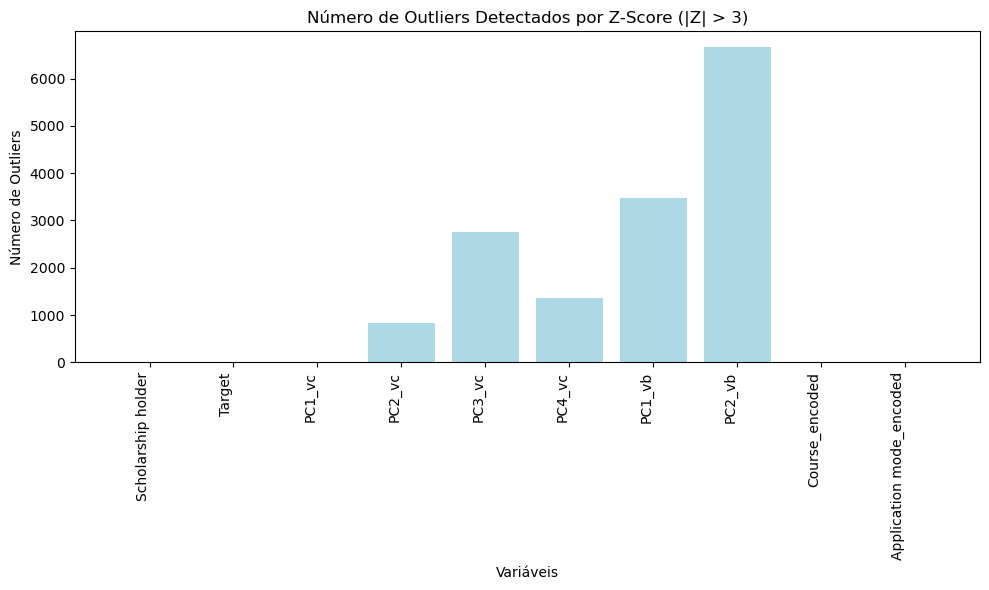

In [33]:
# Plotando os outliers detectados
plt.figure(figsize=(10, 6))
plt.bar(outliers_z.index, outliers_z.values, color='lightblue')
plt.xlabel('Variáveis')
plt.ylabel('Número de Outliers')
plt.title('Número de Outliers Detectados por Z-Score (|Z| > 3)')
plt.xticks(rotation=90, ha='right')  
plt.tight_layout() 

plt.show()

In [39]:
X = df_encoded.drop('Target', axis=1)
X

,Scholarship holder,PC1_vc,PC2_vc,PC3_vc,PC4_vc,PC1_vb,PC2_vb,Course_encoded,Application mode_encoded
0,1,1.377008,-0.032112,0.191097,0.171448,-0.439985,0.047891,0.200376,0.188739
1,0,-1.478385,-0.372044,1.695335,-0.000335,-0.439985,0.047891,0.197820,0.292994
2,0,-3.314795,0.357917,-0.083664,-0.010029,-0.439985,0.047891,0.369952,0.291961
3,1,1.601885,0.522358,0.049436,0.007627,-0.439985,0.047891,0.136434,0.188739
4,0,1.275992,0.118435,-0.010658,0.018867,-0.439985,0.047891,0.135383,0.186608
...,...,...,...,...,...,...,...,...,...
76513,1,0.671912,0.341332,0.172181,-0.191931,-0.439985,0.047891,0.374361,0.292994
76514,0,0.992374,-0.268130,-0.485153,0.376063,-0.439985,0.047891,0.367249,0.186608
76515,0,0.540902,-0.243350,-0.126209,0.305721,-0.439985,0.047891,0.324666,0.291348
76516,0,-3.314795,0.357917,-0.083664,-0.010029,-0.439985,0.047891,0.211124,0.188739


Optimization terminated successfully.
         Current function value: 0.261115
         Iterations 7


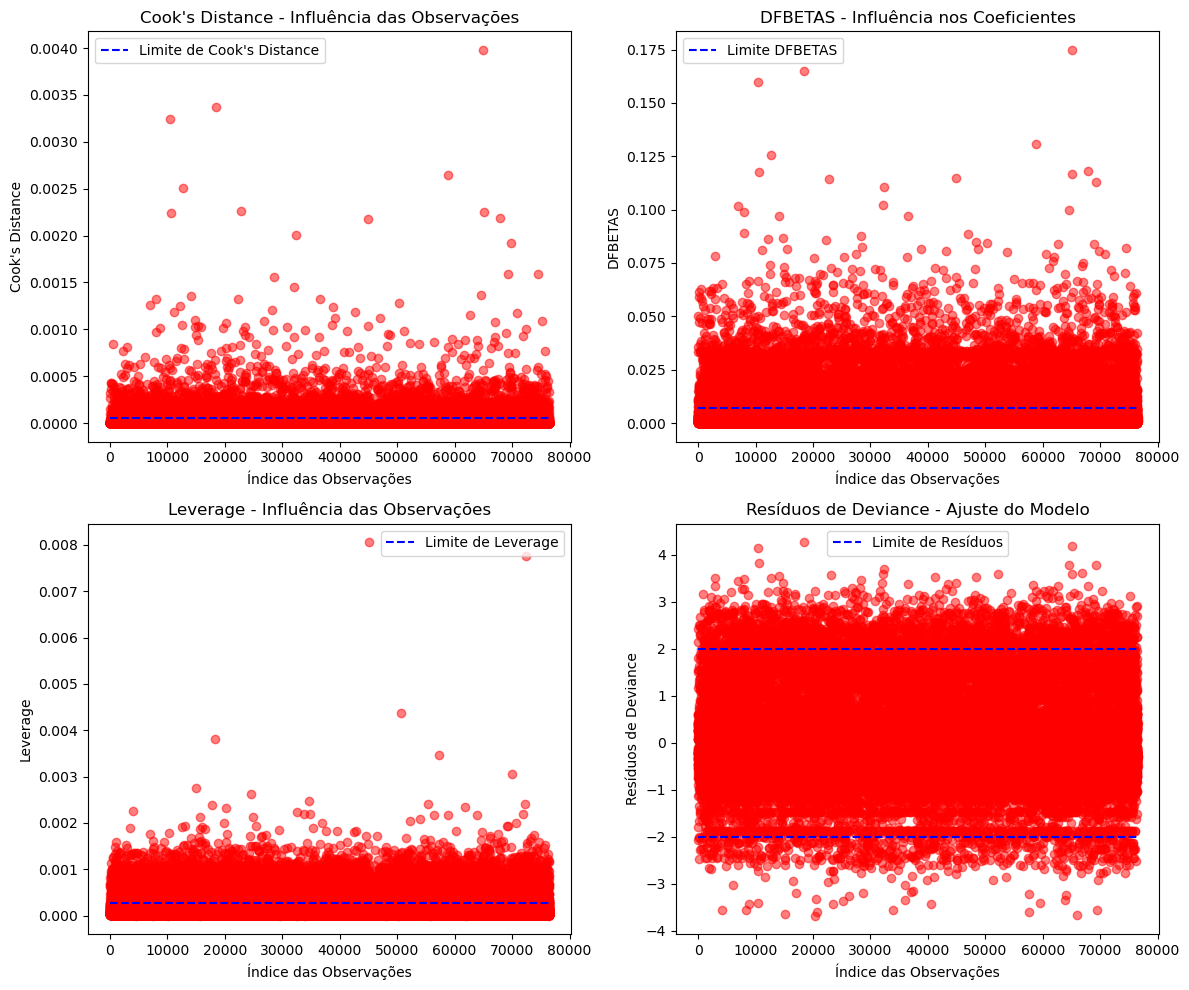

In [47]:
import statsmodels.api as sm

# Definir as variáveis independentes (X) e dependente (y)
X = df_encoded.drop('Target', axis=1)
X = sm.add_constant(X)  
y = df_encoded['Target']

# Ajustar o modelo de regressão logística
model = sm.Logit(y, X)
result = model.fit()

# Obter influência dos pontos
influence = result.get_influence()

# Métricas de influência para regressão logística
cooks_d = influence.cooks_distance[0] 
dfbetas = influence.dfbetas  
leverage = influence.hat_matrix_diag  
deviance_residuals = result.resid_dev 

# Configuração do gráfico
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Cook's Distance
axes[0, 0].scatter(range(len(cooks_d)), cooks_d, color='red', alpha=0.5)
axes[0, 0].hlines(y=4/len(cooks_d), xmin=0, xmax=len(cooks_d), colors='blue', linestyle='--', label='Limite de Cook\'s Distance')
axes[0, 0].set_xlabel('Índice das Observações')
axes[0, 0].set_ylabel('Cook\'s Distance')
axes[0, 0].set_title('Cook\'s Distance - Influência das Observações')
axes[0, 0].legend()

# DFBETAS (Pegando o maior impacto por observação)
axes[0, 1].scatter(range(len(dfbetas)), np.max(np.abs(dfbetas), axis=1), color='red', alpha=0.5)
axes[0, 1].hlines(y=2/np.sqrt(len(dfbetas)), xmin=0, xmax=len(dfbetas), colors='blue', linestyle='--', label='Limite DFBETAS')
axes[0, 1].set_xlabel('Índice das Observações')
axes[0, 1].set_ylabel('DFBETAS')
axes[0, 1].set_title('DFBETAS - Influência nos Coeficientes')
axes[0, 1].legend()

# Leverage (hii)
axes[1, 0].scatter(range(len(leverage)), leverage, color='red', alpha=0.5)
axes[1, 0].hlines(y=2 * (X.shape[1] / len(leverage)), xmin=0, xmax=len(leverage), colors='blue', linestyle='--', label='Limite de Leverage')
axes[1, 0].set_xlabel('Índice das Observações')
axes[1, 0].set_ylabel('Leverage')
axes[1, 0].set_title('Leverage - Influência das Observações')
axes[1, 0].legend()

# Deviance Residuals 
axes[1, 1].scatter(range(len(deviance_residuals)), deviance_residuals, color='red', alpha=0.5)
axes[1, 1].hlines(y=[-2, 2], xmin=0, xmax=len(deviance_residuals), colors='blue', linestyle='--', label='Limite de Resíduos')
axes[1, 1].set_xlabel('Índice das Observações')
axes[1, 1].set_ylabel('Resíduos de Deviance')
axes[1, 1].set_title('Resíduos de Deviance - Ajuste do Modelo')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

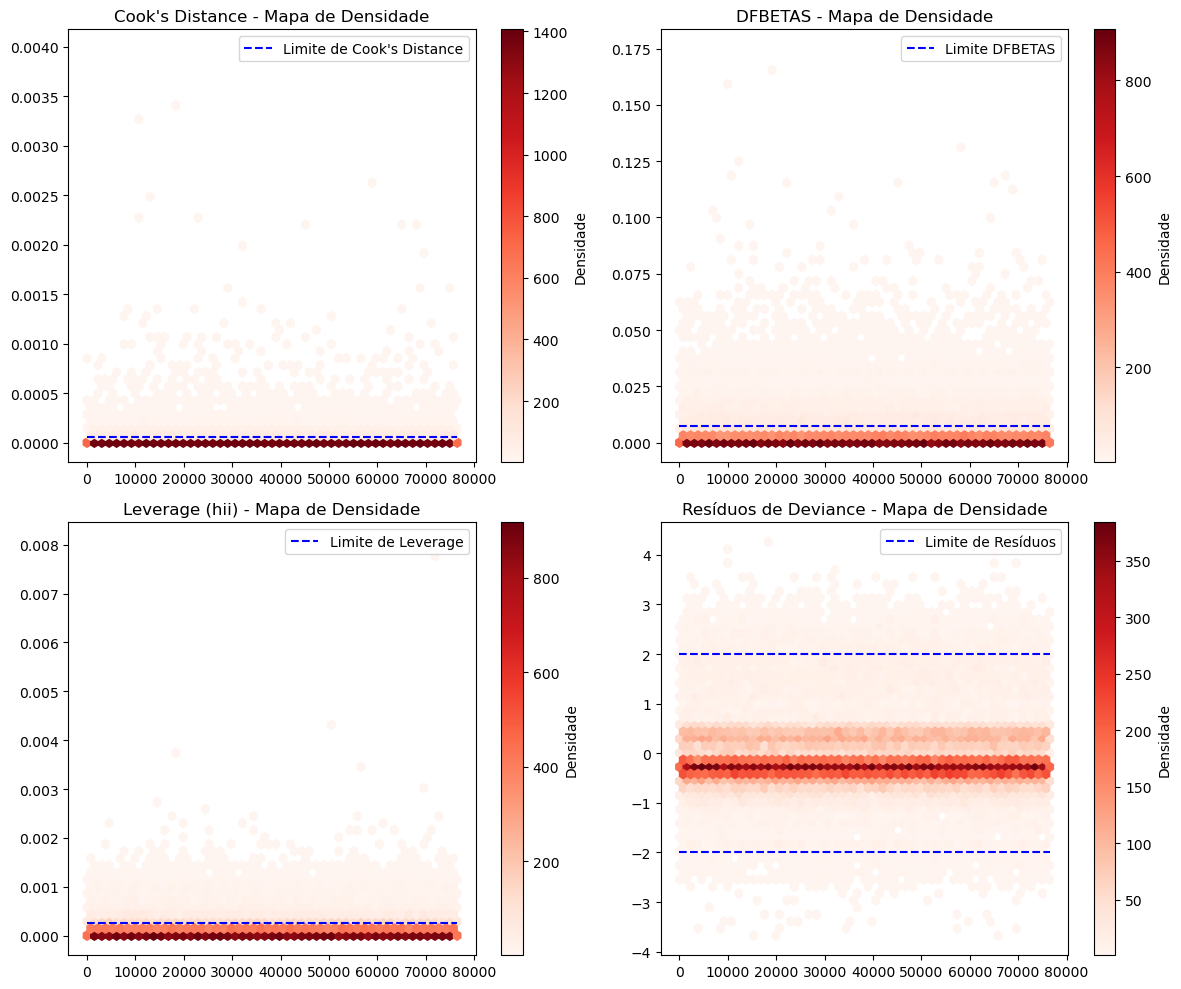

In [49]:
# Criar a figura com 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Cook's Distance - Mapa de Densidade
hb1 = axes[0, 0].hexbin(range(len(cooks_d)), cooks_d, gridsize=50, cmap='Reds', mincnt=1)
axes[0, 0].hlines(y=4/len(cooks_d), xmin=0, xmax=len(cooks_d), colors='blue', linestyle='--', label='Limite de Cook\'s Distance')
axes[0, 0].set_title('Cook\'s Distance - Mapa de Densidade')
axes[0, 0].legend()
fig.colorbar(hb1, ax=axes[0, 0], label='Densidade')

# DFBETAS - Mapa de Densidade (considerando o maior impacto por observação)
dfbetas_max = np.max(np.abs(dfbetas), axis=1)
hb2 = axes[0, 1].hexbin(range(len(dfbetas_max)), dfbetas_max, gridsize=50, cmap='Reds', mincnt=1)
axes[0, 1].hlines(y=2/np.sqrt(len(dfbetas_max)), xmin=0, xmax=len(dfbetas_max), colors='blue', linestyle='--', label='Limite DFBETAS')
axes[0, 1].set_title('DFBETAS - Mapa de Densidade')
axes[0, 1].legend()
fig.colorbar(hb2, ax=axes[0, 1], label='Densidade')

# Leverage (hii) - Mapa de Densidade
hb3 = axes[1, 0].hexbin(range(len(leverage)), leverage, gridsize=50, cmap='Reds', mincnt=1)
axes[1, 0].hlines(y=2 * (X.shape[1] / len(leverage)), xmin=0, xmax=len(leverage), colors='blue', linestyle='--', label='Limite de Leverage')
axes[1, 0].set_title('Leverage (hii) - Mapa de Densidade')
axes[1, 0].legend()
fig.colorbar(hb3, ax=axes[1, 0], label='Densidade')

# Resíduos de Deviance - Mapa de Densidade
hb4 = axes[1, 1].hexbin(range(len(deviance_residuals)), deviance_residuals, gridsize=50, cmap='Reds', mincnt=1)
axes[1, 1].hlines(y=[-2, 2], xmin=0, xmax=len(deviance_residuals), colors='blue', linestyle='--', label='Limite de Resíduos')
axes[1, 1].set_title('Resíduos de Deviance - Mapa de Densidade')
axes[1, 1].legend()
fig.colorbar(hb4, ax=axes[1, 1], label='Densidade')

plt.tight_layout()
plt.show()

# | Engenharia de Features
## | Information Gain

In [52]:
from sklearn.feature_selection import mutual_info_classif

info_gain = mutual_info_classif(X, y, random_state=412)

feature_importance = (pd.DataFrame({'Feature': X.columns, 'Importance': info_gain})
                       .sort_values(by='Importance', ascending=False))
feature_importance

,Feature,Importance
2,PC1_vc,0.343998
3,PC2_vc,0.333786
5,PC4_vc,0.330347
4,PC3_vc,0.330166
7,PC2_vb,0.104483
6,PC1_vb,0.102752
9,Application mode_encoded,0.077699
1,Scholarship holder,0.066470
8,Course_encoded,0.058403
0,const,0.010303


- Organizar secção atual
- Organizar jupyter notebook
- Escrever conclusões e pensamentos
- Explicar (e estudar) técnicas aplicadas
- Decididr se faz sentido nomalizar as variáveis
- Revisar o storytelling
- Escrever conclusão do notebook

# | Criação e Transformação de Variáveis

# | Normalização de Variáveis

In [46]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_scaled = df_sub.copy()
df_scaled[df_sub.select_dtypes(include=['number']).columns] = scaler.fit_transform(df_sub[df_sub.select_dtypes(include=['number']).columns])

df_scaled

,Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Tuition fees up to date,Scholarship holder,Course,Application mode,Target
0,0.677640,0.855619,0.718660,0.505317,0.34498,1.744178,0.131258,-0.902423,-0.702745
1,-0.066414,0.304727,-1.445110,-1.735681,0.34498,-0.573336,0.131258,0.056682,1.422992
2,-1.554522,-1.898842,-1.445110,-1.735681,0.34498,-0.573336,0.140130,0.056682,1.422992
3,1.049667,0.493027,1.079288,0.575895,0.34498,1.744178,0.276537,-0.902423,-0.702745
4,0.677640,0.558010,0.718660,0.596330,0.34498,-0.573336,0.276537,-0.902423,-0.702745
...,...,...,...,...,...,...,...,...,...
76513,0.677640,0.127428,0.358031,0.175607,0.34498,1.744178,0.140130,0.056682,-0.702745
76514,-0.066414,0.570674,0.718660,0.766123,0.34498,-0.573336,0.140130,-0.902423,-0.702745
76515,-0.066414,0.475693,0.358031,0.319855,0.34498,-0.573336,0.046419,0.056682,-0.702745
76516,-1.554522,-1.898842,-1.445110,-1.735681,0.34498,-0.573336,0.038102,-0.902423,1.422992
